# DDPG

## 0. Paper

### Info
* Title: Continuous Control with Deep Reinforcement Learning
* Author: Timothy P. Lillicrap
* Task: Reinforcement Learning
* Link: https://arxiv.org/abs/1509.02971


### Features
* Environment: Pendulum

### Reference
* https://github.com/soumik12345/DDPG

## 1. Setting

In [ ]:
import os
import copy
import gym
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchsummary import torchsummary

In [ ]:
class CONFIG:
    exploration_noise = 0.1
    batch_size = 256
    start_step = int(5e4)
    step_size = int(3e5)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    env = 'Pendulum-v0'
    base_dir = '/content/drive/Shared drives/Yoon/Project/Doing/Deep Learning Paper Implementation'

## 2. Data

In [ ]:
def create_env():
    env = gym.make(CONFIG.env)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = env.action_space.high[0]
    return env, state_dim, action_dim, max_action

In [ ]:
env, state_dim, action_dim, max_action = create_env()
print('observation space : ', env.observation_space)
print('action space : ', env.action_space)

observation space :  Box(-8.0, 8.0, (3,), float32)
action space :  Box(-2.0, 2.0, (1,), float32)


## 3. Model

In [ ]:
class ReplayBuffer(object):
    def __init__(self, state_dim, action_dim, device, buffer_size=int(1e6)):
        self.device = device
        self.buffer_size = buffer_size
        self.ptr = 0
        self.size = 0
        
        self.state = np.zeros((buffer_size, state_dim))
        self.action = np.zeros((buffer_size, action_dim))
        self.next_state = np.zeros((buffer_size, state_dim))
        self.reward = np.zeros((buffer_size, 1))
        self.done = np.zeros((buffer_size, 1))

    def add(self, state, action, next_state, reward, done):
        self.state[self.ptr] = state
        self.action[self.ptr] = action
        self.next_state[self.ptr] = next_state
        self.reward[self.ptr] = reward
        self.done[self.ptr] = done

        self.ptr = (self.ptr + 1) % self.buffer_size
        self.size = min(self.size + 1, self.buffer_size)
    
    def sample(self, batch_size=128):
        indices = np.random.randint(0, self.size, size=batch_size)
        return (
            torch.Tensor(self.state[indices]).to(self.device),
            torch.Tensor(self.action[indices]).to(self.device),
            torch.Tensor(self.next_state[indices]).to(self.device),
            torch.Tensor(self.reward[indices]).to(self.device),
            torch.Tensor(self.done[indices]).to(self.device),
        )

In [ ]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.max_action = max_action

        self.fc1 = nn.Linear(state_dim, 400)
        self.fc2 = nn.Linear(400, 300)
        self.fc3 = nn.Linear(300, action_dim)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.tanh(self.fc3(x))
        return x * self.max_action

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim+action_dim, 400)
        self.fc2 = nn.Linear(400, 300)
        self.fc3 = nn.Linear(300, 1)
        self.relu = nn.ReLU()
    
    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)


class DDPG(object):
    def __init__(self, state_dim, action_dim, max_action, device, discount=0.99, tau=0.005):
        self.device = device
        self.discount = discount
        self.tau = tau

        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = copy.deepcopy(self.actor)
        self.actor_optim = torch.optim.Adam(self.actor.parameters())
        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = copy.deepcopy(self.critic)
        self.critic_optim = torch.optim.Adam(self.critic.parameters())


    def act(self, state):
        state = torch.Tensor(state).to(self.device)
        action = self.actor(state).cpu().data.numpy()
        return action

    def train(self, replay_buffer):
        state, action, next_state, reward, done = replay_buffer.sample()
        target_q = self.critic_target(next_state, self.actor_target(next_state))
        target_q = reward + ((1. - done) * self.discount * target_q).detach()
        current_q = self.critic(state, action)
        critic_loss = F.mse_loss(current_q, target_q)
        self.critic_optim.zero_grad()
        critic_loss.backward()
        self.critic_optim.step()

        actor_loss = -self.critic(state, self.actor(state)).mean()
        self.actor_optim.zero_grad()
        actor_loss.backward()
        self.actor_optim.step()

        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        return critic_loss.item(), actor_loss.item()

    def save(self):
        ckpt = {
            'critic': self.critic.state_dict(),
            'critic_optim': self.critic_optim.state_dict(),
            'actor': self.actor.state_dict(),
            'actor_optim': self.actor_optim.state_dict()
        }
        torch.save(ckpt, 'ckpt.pt')
    
    def load(self):
        ckpt = torch.load('ckpt.pt')
        self.critic.load_state_dict(ckpt['critic'])
        self.critic_target.load_state_dict(ckpt['critic'])
        self.critic_optim.load_state_dict(ckpt['critic_optim'])

        self.actor.load_state_dict(ckpt['actor'])
        self.actor_target.load_state_dict(ckpt['actor'])
        self.actor_optim.load_state_dict(ckpt['actor_optim'])

## 4. Experiment

In [ ]:
def train():
    env, state_dim, action_dim, max_action = create_env()
    agent = DDPG(state_dim, action_dim,max_action, CONFIG.device)
    replay_buffer = ReplayBuffer(state_dim, action_dim, CONFIG.device)
    
    episode_rewards = []
    episode, episode_reward, episode_step = 0, 0, 0

    state, done = env.reset(), False
    pbar = tqdm(range(CONFIG.step_size))
    for st in pbar:
        episode_step += 1

        if st < CONFIG.start_step:
            action = env.action_space.sample()
        else:
            noise = np.random.normal(0, max_action * 0.1, size=action_dim)
            action = agent.act(state) + noise
            action = action.clip(-max_action, max_action)
        
        next_state, reward, done, _ = env.step(action)
        _done = done if episode_step < env._max_episode_steps else False
        replay_buffer.add(state, action, next_state, reward, _done)

        state = next_state
        episode_reward += reward

        if st >= CONFIG.start_step:
            agent.train(replay_buffer)
        if done:
            pbar.set_postfix(log=f'EP {episode:05d} | Reward {episode_reward:.3f}')
            state, done = env.reset(), False
            episode_rewards.append(episode_reward)
            episode_reward, episode_step = 0, 0
            episode += 1
    
    agent.save()
    return episode_rewards

In [ ]:
def test(num_episode):
    env, state_dim, action_dim, max_action = create_env()
    agent = DDPG(state_dim, action_dim,max_action, CONFIG.device)
    agent.load()

    for ep in range(num_episode):
        episode_reward = 0
        state, done = env.reset(), False
        while not done:
            action = agent.act(state)
            state, reward, done, _ = env.step(action)
            episode_reward += reward
        print(f'EP {ep:02d} | Reward {episode_reward:.3f}')
    
    env.close()

In [ ]:
train_rewards = train()

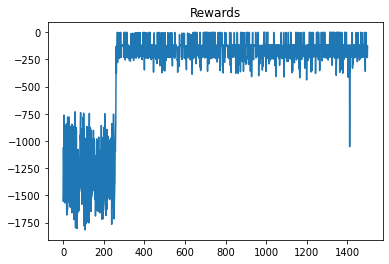

In [ ]:
plt.plot(train_rewards)
plt.title('Rewards')
plt.show()

In [ ]:
test(10)

EP 00 | Reward -11.633
EP 01 | Reward -128.366
EP 02 | Reward -236.354
EP 03 | Reward -249.250
EP 04 | Reward -11.529
EP 05 | Reward -226.311
EP 06 | Reward -130.351
EP 07 | Reward -128.865
EP 08 | Reward -123.923
EP 09 | Reward -241.677
